In [5]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs/src

fatal: destination path 'src' already exists and is not an empty directory.


In [6]:
!ls src

signnames.csv
test.p
train.p
valid.p


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [8]:
np.random.seed(0)

In [9]:
with open('src/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('src/valid.p', 'rb') as f:
    val_data = pickle.load(f)
with open('src/test.p', 'rb') as f:
    test_data = pickle.load(f)
    
print(type(train_data))
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

<class 'dict'>


In [10]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


In [11]:
assert(X_train.shape[0] == y_train.shape[0])
assert(X_val.shape[0] == y_val.shape[0])
assert(X_test.shape[0] == y_test.shape[0])
assert(X_train.shape[1:] == (32, 32, 3))
assert(X_val.shape[1:] == (32, 32, 3))
assert(X_test.shape[1:] == (32, 32, 3))

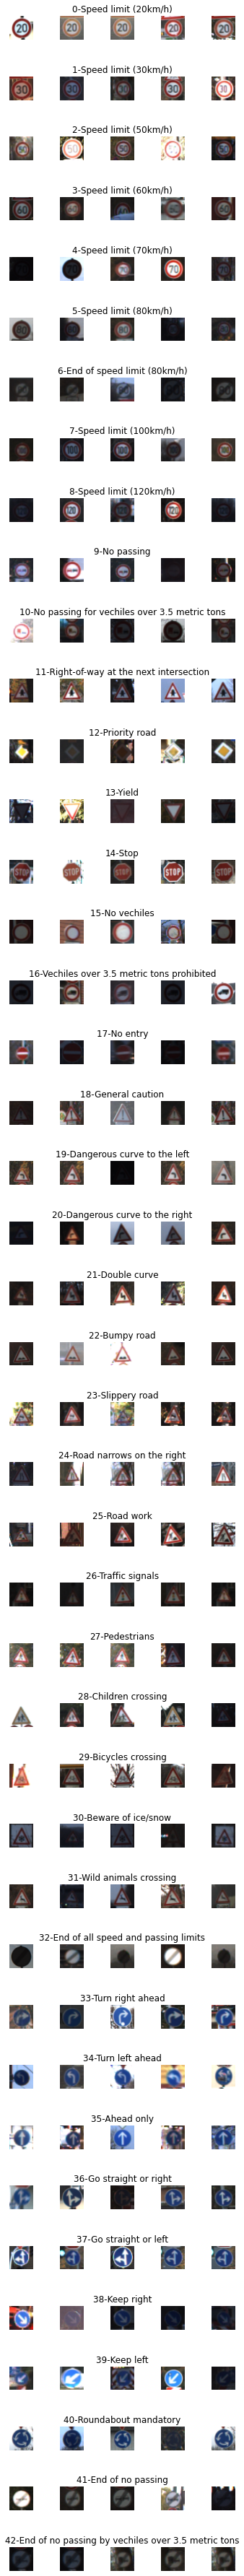

In [12]:
data = pd.read_csv('src/signnames.csv')

num_of_samples=[]
 
cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
      x_selected = X_train[y_train == j]
      axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
      axs[j][i].axis("off")
      if i == 2:
        axs[j][i].set_title(str(j) + "-" + row["SignName"])
        num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


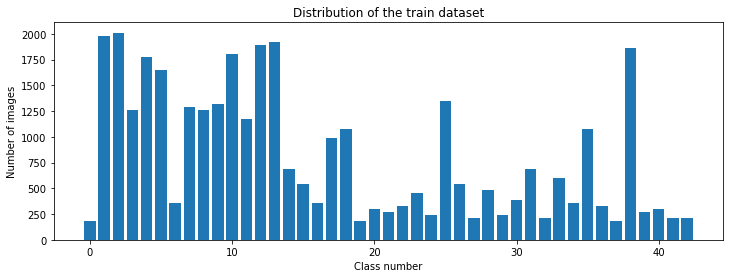

In [13]:
print(num_of_samples)
plt.figure(figsize=(12,4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


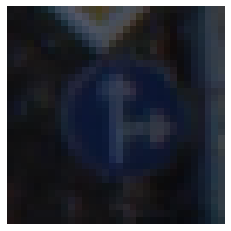

In [14]:
import cv2

plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

In [15]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

(32, 32)


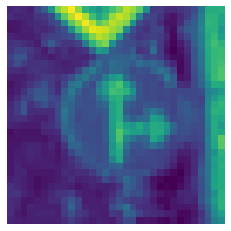

In [16]:
img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [17]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

(32, 32)


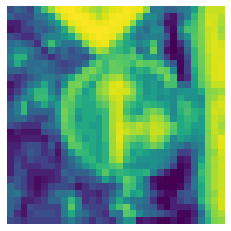

In [18]:
img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [19]:
def preprocessing(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocessing, X_train)))
X_val = np.array(list(map(preprocessing, X_val)))
X_test = np.array(list(map(preprocessing, X_test)))

(34799, 32, 32)


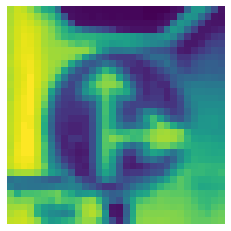

In [20]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis("off")
print(X_train.shape)

In [34]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)

In [36]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.2,
                            shear_range=0.1,
                            rotation_range=10.)

datagen.fit(X_train)

(15, 32, 32, 1)


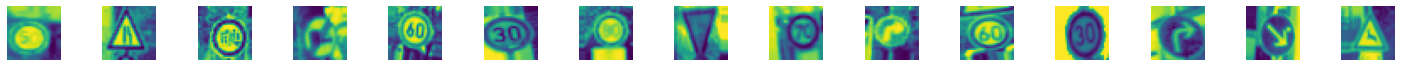

In [38]:
batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")
    
print(X_batch.shape)

In [22]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 1)
(4410, 32, 32, 1)
(12630, 32, 32, 1)


In [23]:
y_train = to_categorical(y_train, 43)
y_val = to_categorical(y_val, 43)
y_test = to_categorical(y_test, 43)

In [24]:
def modified_model():
    model = Sequential()
    model.add(Conv2D(30, (5, 5), input_shape=(32, 32, 1), activation='relu'))
    model.add(Conv2D(30, (5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    
    model.add(Conv2D(15, (3, 3), activation = 'relu'))
    model.add(Conv2D(15, (3, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(Adam(lr=0.01), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    return model

In [25]:
model = modified_model()
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 30)        780       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 30)        22530     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 30)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 15)        4065      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 15)          2040      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 4, 15)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 15)          0

In [26]:
history = model.fit_generator(datagen.flow(X_train, y_train, batch_size=50),
                            steps_per_epoch=2000,
                            epochs=10,
                            validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
87/87 [==============================] - 77s 890ms/step - loss: 3.6033 - accuracy: 0.0546 - val_loss: 3.5563 - val_accuracy: 0.0544
Epoch 2/10
87/87 [==============================] - 79s 906ms/step - loss: 3.4848 - accuracy: 0.0546 - val_loss: 3.5538 - val_accuracy: 0.0544
Epoch 3/10
87/87 [==============================] - 82s 941ms/step - loss: 3.4849 - accuracy: 0.0567 - val_loss: 3.5571 - val_accuracy: 0.0544
Epoch 4/10
87/87 [==============================] - 78s 894ms/step - loss: 3.4843 - accuracy: 0.0558 - val_loss: 3.5586 - val_accuracy: 0.0544
Epoch 5/10
87/87 [==============================] - 78s 896ms/step - loss: 3.4839 - accuracy: 0.0553 - val_loss: 3.5568 - val_accuracy: 0.0544
Epoch 6/10
87/87 [==============================] - 76s 875ms/step - loss: 3.4828 - accuracy: 0.0565 - val_loss: 3.5604 - val_accuracy: 0.0544
Epoch 7/10
87/87 [==============================] - 76s 876ms/step - loss: 3.4822 - accuracy: 0.0564 - val_loss: 3.5522 - val_accuracy: 0.0544

Text(0.5, 0, 'epoch')

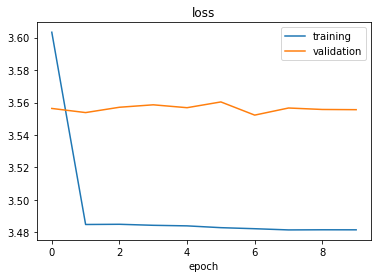

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

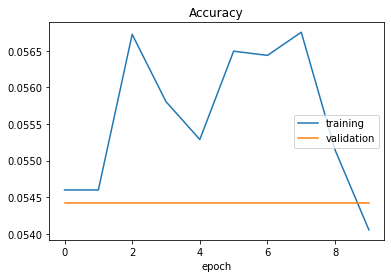

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [29]:
score = model.evaluate(X_test, y_test, verbose = 0)
print('Test Score:', score[0])
print('Test Accuracy:', score[1])

Test Score: 3.4634432792663574
Test Accuracy: 0.059382423758506775


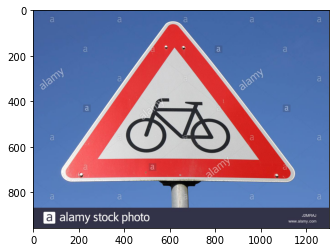

In [30]:
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/J2MRAJ/german-road-sign-bicycles-crossing-J2MRAJ.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

(32, 32)


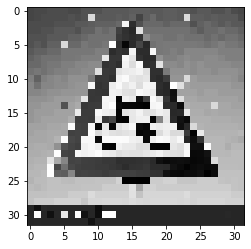

In [31]:
img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocessing(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [32]:
img = img.reshape(1, 32, 32, 1)

In [33]:
print("predicted sign: "+ str(model.predict_classes(img)))

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
predicted sign: [2]
